# Subject Verb Agreement

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
import seaborn as sns
import scipy
import wandb

from matplotlib.ticker import MaxNLocator
from matplotlib import cm, font_manager as fm, pyplot as plt
import matplotlib as mpl

### Preamble
Paths, colors, and WandB stuff

In [2]:
DATA_DIR = "../data/lgd_sva/"
MODEL_ID = "bf-google/bert_uncased_L-6_H-512_A-8"
RESULTS_DIR = os.path.join(DATA_DIR, MODEL_ID, "results/entropy/")

AGG_ENTROPY_RESULTS_PATH = os.path.join(RESULTS_DIR, "agg_entropy_results.csv")
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

In [3]:
# Plot formatting
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

try:
    # Set the font properties globally
    font_path = './fonts/cmunbx.otf'
    font_prop = fm.FontProperties(fname=font_path, size=12)
    plt.rc('font', family=font_prop.get_name())
except:
    print("Unable to set font to Computer Modern (cmunbx.otf)")

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(
    os.getcwd(), "sva_entropy.ipynb"
)
entity, PROJECT_NAME = "kdu", "eval_bert_entropy"  # set to your entity and project
config = {
    "MODEL_ID": MODEL_ID,
    "AGG_ENTROPY_RESULTS_PATH": AGG_ENTROPY_RESULTS_PATH,
}
run = wandb.init(
    project=PROJECT_NAME,
    name=f"analyze_sva_entropy_{datetime.now().isoformat(sep='_', timespec='seconds')}",
    tags=["analysis"],
    config=config,
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


{'MODEL_ID': 'bf-google/bert_uncased_L-6_H-512_A-8', 'AGG_ENTROPY_RESULTS_PATH': '../data/lgd_sva/bf-google/bert_uncased_L-6_H-512_A-8/results/entropy/agg_entropy_results.csv'}


## Load Data

In [5]:
df = pd.read_csv(AGG_ENTROPY_RESULTS_PATH)
df['num_tokens'] = df.groupby('sentence_index')['sentence_index'].transform('count')
df

,sentence_index,is_correct,num_distractors,correct_word,correct_word_logit,incorrect_word,incorrect_word_logit,token,entropy,masked_sentence,num_tokens
0,214,True,1,opens,15.566561,open,10.901229,[CLS],270.262745,b'the concept of semisets ***mask*** the way f...,20
1,214,True,1,opens,15.566561,open,10.901229,the,269.398821,b'the concept of semisets ***mask*** the way f...,20
2,214,True,1,opens,15.566561,open,10.901229,concept,270.725252,b'the concept of semisets ***mask*** the way f...,20
3,214,True,1,opens,15.566561,open,10.901229,of,269.153706,b'the concept of semisets ***mask*** the way f...,20
4,214,True,1,opens,15.566561,open,10.901229,semi,270.257410,b'the concept of semisets ***mask*** the way f...,20
...,...,...,...,...,...,...,...,...,...,...,...
32498,701,True,3,make,22.093514,makes,19.865558,up,273.476586,"b'but the features of the face , with its slig...",58
32499,701,True,3,make,22.093514,makes,19.865558,the,275.265516,"b'but the features of the face , with its slig...",58
32500,701,True,3,make,22.093514,makes,19.865558,eyes,275.113988,"b'but the features of the face , with its slig...",58
32501,701,True,3,make,22.093514,makes,19.865558,.,274.934502,"b'but the features of the face , with its slig...",58


In [6]:
print(df.groupby("sentence_index")["is_correct"].agg("mean").value_counts())
print(df.groupby("sentence_index").agg("mean")["num_distractors"].value_counts())

1.0    937
0.0     63
Name: is_correct, dtype: int64
1.0    250
2.0    250
3.0    250
4.0    250
Name: num_distractors, dtype: int64


/tmp/ipykernel_197584/2231592377.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby("sentence_index").agg("mean")["num_distractors"].value_counts())


## Prepare Dataframe

In [7]:
df_analysis = df.groupby('sentence_index').agg({'entropy': 'mean', 'num_distractors': 'mean', 'num_tokens': 'mean', 'correct_word_logit': 'mean', 'incorrect_word_logit': 'mean'})

df_analysis["logit_diff"] = abs(df_analysis["correct_word_logit"] - df_analysis["incorrect_word_logit"]) / (abs(df_analysis["correct_word_logit"]) + abs(df_analysis["incorrect_word_logit"]))

df_analysis
table = wandb.Table(dataframe=df_analysis)
wandb.log({"entropy_per_sentence_df": table})

## Plot 1

In [8]:
entropy = df_analysis["entropy"].to_numpy()
num_tokens = df_analysis["num_tokens"].to_numpy()
num_distractors = df_analysis["num_distractors"].to_numpy().astype(int)
unique_distractors, distractor_counts = np.unique(num_distractors, return_counts= True)

In [9]:
cmap = cm.coolwarm
colors = cmap(np.linspace(0.0, 1.0, int(max(unique_distractors))))
color_map = {i+1: row for i, row in enumerate(colors)}
color_map

{1: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 2: array([0.66725292, 0.77917646, 0.99295921, 1.        ]),
 3: array([0.9682034 , 0.7208441 , 0.61229299, 1.        ]),
 4: array([0.70567316, 0.01555616, 0.15023281, 1.        ])}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


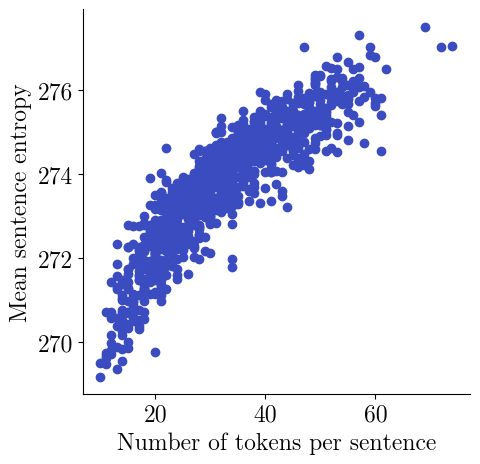

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fontsize = 17

# axs.set_title(r'entropy semiring on subject-verb task', loc = "left", fontsize = fontsize, x=0)
#scatter = axs.scatter(num_tokens, entropy, c=num_distractors, cmap=cmap, alpha=0.2) # s=num_distractors*50
scatter = axs.scatter(num_tokens, entropy, c=color_map[1]) # s=num_distractors*50

#handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
#labels = list(unique_distractors)
#legend = axs.legend(handles, labels, loc="lower right", title="number of\ndistractors", title_fontsize=fontsize-2, fontsize=fontsize-2)

axs.set_xlabel(r'Number of tokens per sentence', fontsize=fontsize)
axs.set_ylabel(r'Mean sentence entropy', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
axs.tick_params(axis='both', which='minor', labelsize=fontsize)

save_path_pdf = os.path.join(PLOTS_DIR, "entropy_tokens.pdf")
save_path = os.path.join(PLOTS_DIR, "entropy_tokens.png")
fig.savefig(save_path_pdf, dpi=200, bbox_inches='tight')
fig.savefig(save_path, dpi=200, bbox_inches='tight')
wandb.log({"entropy_vs_num_tokens": wandb.Image(save_path)})

## Plot 2

In [11]:
df_analysis_2 = df_analysis.groupby("num_distractors")['entropy'].apply(list)
num_distractors = df_analysis_2.index
distr_entropy = df_analysis_2.to_numpy()

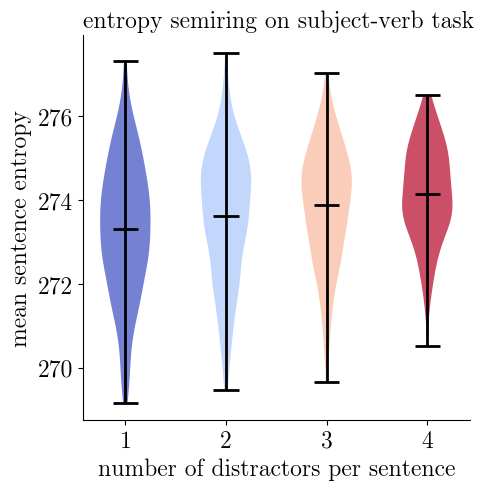

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fontsize = 17

axs.set_title(r'entropy semiring on subject-verb task', loc = "left", fontsize = fontsize, x=0)
violins = axs.violinplot(distr_entropy, showmeans=True)

for pc, color in zip(violins['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('none')
    pc.set_alpha(0.7)
    
for partname in ['cmeans','cbars','cmins','cmaxes']: 
    vp = violins[partname] 
    vp.set_edgecolor('black' ) 
    vp.set_linewidth(2) 

axs.set_xlabel(r'number of distractors per sentence', fontsize=fontsize)
axs.set_ylabel(r'mean sentence entropy', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
axs.tick_params(axis='both', which='minor', labelsize=fontsize)

save_path_pdf = os.path.join(PLOTS_DIR, "entropy_vs_num_distractors.pdf")
save_path = os.path.join(PLOTS_DIR, "entropy_vs_num_distractors.png")
fig.savefig(save_path_pdf, dpi=200, bbox_inches='tight')
fig.savefig(save_path, dpi=200, bbox_inches='tight')
wandb.log({"entropy_vs_num_distractors": wandb.Image(save_path)})

## Plot 3

In [13]:
entropy = df_analysis["entropy"].to_numpy()
num_tokens = df_analysis["num_tokens"].to_numpy()
correct_word_logit = df_analysis["correct_word_logit"].to_numpy()
logit_diff = df_analysis["logit_diff"].to_numpy()

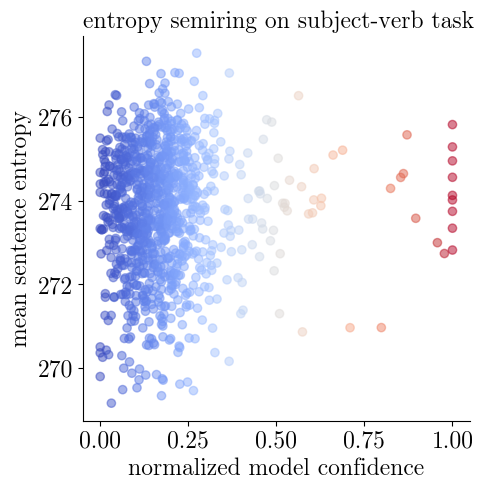

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fontsize = 17

axs.set_title(r'entropy semiring on subject-verb task', loc = "left", fontsize = fontsize, x=0)
scatter = axs.scatter(logit_diff, entropy, c=logit_diff, cmap=cmap, alpha=0.5)

axs.set_xlabel(r'normalized model confidence', fontsize=fontsize)
axs.set_ylabel(r'mean sentence entropy', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
axs.tick_params(axis='both', which='minor', labelsize=fontsize)
#axs.set_xlim(0, 1.0)

save_path_pdf = os.path.join(PLOTS_DIR, "entropy_vs_confidence.pdf")
save_path = os.path.join(PLOTS_DIR, "entropy_vs_confidence.png")
fig.savefig(save_path_pdf, dpi=200, bbox_inches='tight')
fig.savefig(save_path, dpi=200, bbox_inches='tight')
wandb.log({"entropy_vs_confidence": wandb.Image(save_path)})

## Plot 4

In [15]:
df_analysis_2 = df_analysis.copy(deep=True)
bins = np.arange(df_analysis_2["num_tokens"].min(),df_analysis_2["num_tokens"].max(),10)
df_analysis_2['num_tokens_binned'] = pd.cut(df_analysis_2['num_tokens'], bins)
#df_analysis_2['num_distractors'] = np.where(df_analysis_2["num_distractors"] == 1.0, "=1", ">1")

global_unique_distractors = len(df_analysis_2["num_distractors"].unique())
unique_token_bins = df_analysis_2["num_tokens_binned"].dropna().sort_values().unique().to_numpy()
unique_token_bins_len = len(unique_token_bins)

df_analysis_3 = df_analysis_2.groupby(["num_tokens_binned","num_distractors"])['entropy'].apply(list)
num_distractors = df_analysis_3.index
distractor_entropy = df_analysis_3.to_numpy()
print("unique_token_bins_len", unique_token_bins_len, "global_unique_distractors", global_unique_distractors)

unique_token_bins_len 6 global_unique_distractors 4


In [16]:
cmap = cm.coolwarm
colors = cmap(np.linspace(0.0, 1.0, global_unique_distractors))

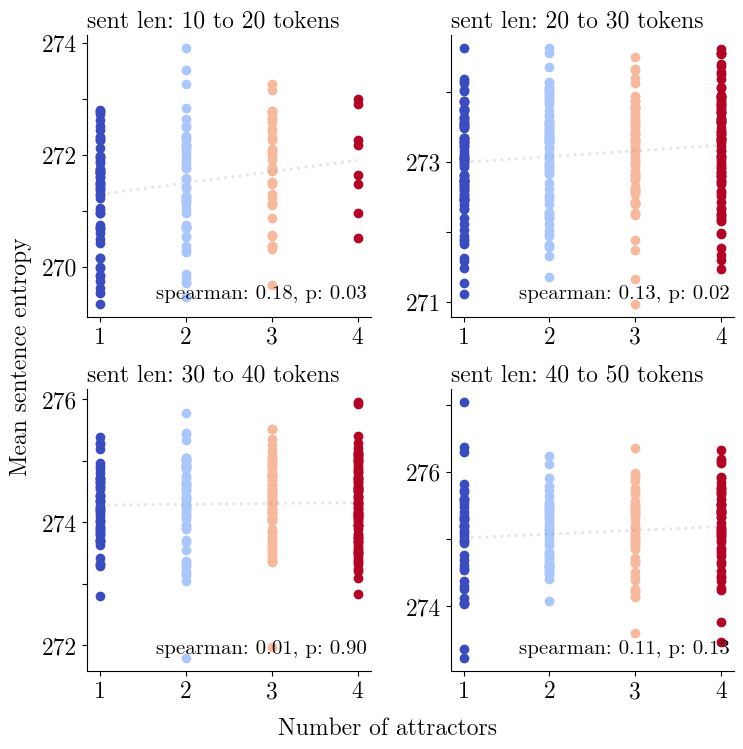

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7), constrained_layout=True, gridspec_kw={"wspace":0.1, "hspace":0.05})

fontsize = 17

for i, ax in enumerate(axs.flatten()):
    lower = int(unique_token_bins[i].left)
    upper = int(unique_token_bins[i].right)
    ax.set_title(f"sent len: {lower} to {upper} tokens", loc = "left", fontsize = fontsize, x=-0.0)

    unique_distractors = df_analysis_2[df_analysis_2["num_tokens_binned"] == unique_token_bins[i]]["num_distractors"].unique()
    entropies = list()
    x_s = list()
    
    for j in range(0,len(unique_distractors)):
        entropy = distractor_entropy[(global_unique_distractors*i)+j]
        x = np.ones(len(entropy)) * (j+1)
        violins = ax.scatter(x, entropy, color=colors[j])
        
        entropies += list(entropy)
        x_s += list(x)
        

    #corr, corr_p = scipy.stats.pearsonr(x_s, y=entropies)
    #corr, corr_p = scipy.stats.kendalltau(x_s, y=entropies)
    corr, corr_p = scipy.stats.spearmanr(x_s, b=entropies)
    
    m, b = np.polyfit(x_s, entropies, 1)
    x = np.arange(1,len(unique_distractors)+1,1)
    ax.plot(x, m*x+b, color="grey", alpha=0.2, linestyle= ":", linewidth= 2)
    
    ax.text(0.985, 0.05, f'spearman: {round(corr,2):.2f}, p: {round(corr_p,2):.2f}',
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes,
        color='black', fontsize=fontsize-2)

    #ax.set_xticklabels(["0", "=1", ">1"], rotation='horizontal', fontsize=fontsize)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) 
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)

fig.text(0.5, -0.04, r'Number of attractors', ha='center', fontsize=fontsize)
fig.text(-0.04, 0.5, r'Mean sentence entropy', va='center', rotation='vertical', fontsize=fontsize)
    
save_path_pdf = os.path.join(PLOTS_DIR, "entropy_vs_num_attractors_normalized.pdf")
save_path = os.path.join(PLOTS_DIR, "entropy_vs_num_attractors_normalized.png")
fig.savefig(save_path_pdf, dpi=200, bbox_inches='tight')
fig.savefig(save_path, dpi=200, bbox_inches='tight')
wandb.log({"entropy_vs_num_attractors_normalized": wandb.Image(save_path)})

In [18]:
df_correct_and_distractors = df.groupby("sentence_index")["is_correct", "num_distractors"].agg("mean")
df_correct_and_distractors[df_correct_and_distractors["is_correct"] == 1.0]
count_distractors = df_correct_and_distractors.groupby("num_distractors")["is_correct"].agg("count")
count_distractors.name = "count"

percent_correct_per_distractors = df_correct_and_distractors[df_correct_and_distractors["is_correct"] == 1.0]["num_distractors"].value_counts() / count_distractors
percent_correct_per_distractors.name = "accuracy_per_na"
accuracy_per_na = pd.concat([count_distractors, percent_correct_per_distractors], axis=1)
wandb.log({"accuracy_per_na": accuracy_per_na})
accuracy_per_na


/tmp/ipykernel_197584/1375523848.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_correct_and_distractors = df.groupby("sentence_index")["is_correct", "num_distractors"].agg("mean")


,count,accuracy_per_na
1.0,250,0.952
2.0,250,0.932
3.0,250,0.944
4.0,250,0.920


In [19]:
wandb.finish()